# Imports and Constants

In [30]:
import sys
# sys.path is a list of absolute path strings
sys.path.append('..')

from rhythm_regression.misc import rational_numbers
import rhythm_regression.notebook_tools as nbt
from generate_sample_matchings import *
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm

RANDOM_SEED = 7202001  # Release Date of Spirited Away

In [2]:
TEMPO = 120

QUARTER_NOTE = 60 / TEMPO
EIGHTH_NOTE = QUARTER_NOTE / 2
SIXTEENTH_NOTE = QUARTER_NOTE / 4

RHYTHM_BANK = [QUARTER_NOTE, EIGHTH_NOTE, SIXTEENTH_NOTE]
RHYTHM_BANK_PMF = [0.2, 0.3, 0.5]


MONOTONICITY_CRUCNH_FACTOR = 0.9

In [74]:
def delete_notes(t, deletion_rate):
    deletion_indices = np.argwhere(np.random.random(len(t)) < deletion_rate).flatten()
    t = np.delete(t, deletion_indices)
    return t

def insert_notes(t, insertion_rate):
    insertion_indices = np.argwhere(np.random.random(len(t)) < insertion_rate).flatten()
    for i in insertion_indices:
        insertion_interval = (max(0, i-1), i)
        new_note = np.random.uniform(t[insertion_interval[0]], t[insertion_interval[1]])
        t = np.insert(t, i, new_note)

    return t

def augment_space(t, space_augmentation_rate):
    space_augmentation_indices = np.argwhere(np.random.random(len(t)) < space_augmentation_rate).flatten()
    augmentation_amounts = np.random.choice(RHYTHM_BANK, p=RHYTHM_BANK_PMF, size=len(space_augmentation_indices))

    for i in range(len(space_augmentation_indices)):
        t[space_augmentation_indices[i]:] += augmentation_amounts[i]

    return t

def reduce_space(t, space_reduction_rate):
    space_reduction_indices = np.argwhere(np.random.random(len(t)) < space_reduction_rate).flatten()
    reduction_amounts = np.random.choice(RHYTHM_BANK, p=RHYTHM_BANK_PMF, size=len(space_reduction_indices))

    for i in range(len(space_reduction_indices)):
        if space_reduction_indices[i] != 0:
            maximum_reduction = t[space_reduction_indices[i]] - t[space_reduction_indices[i]-1]
            if reduction_amounts[i] >= maximum_reduction:
                # in order to keep t strictly increasing, we cannot subtract 
                # equal to or more space than was originally there.
                reduction_amounts[i] = MONOTONICITY_CRUCNH_FACTOR * maximum_reduction

        t[space_reduction_indices[i]:] -= reduction_amounts[i]

    return t

def add_noise(t, std):
    for i in range(len(t)):
        
        noise = np.random.normal(0, std)

        if i > 0:
            min_noise = t[i-1] - t[i] # signed distance
            if noise < min_noise:
#                print('low clipping noise')
                noise = MONOTONICITY_CRUCNH_FACTOR * min_noise

        if i < len(t) - 1:
            max_noise = t[i+1] - t[i]
            if noise > max_noise:
#                print('high clipping noise')
                noise = MONOTONICITY_CRUCNH_FACTOR * max_noise

        t[i] += noise

    return t
            

def assert_monotonicly_increasing(a):
    assert(np.all(a[1:] >= a[:-1]))

In [75]:
def generate_example(m_notes, deletion_rate, insertion_rate, space_augmentation_rate, space_reduction_rate):
    m_diff = np.random.choice(RHYTHM_BANK, p=RHYTHM_BANK_PMF, size=m_notes-1)
    m = np.cumsum(m_diff)
    m = np.insert(m, 0, 0)

    t = np.copy(m)

    t = delete_notes(t, deletion_rate)
    assert_monotonicly_increasing(t)

    t = insert_notes(t, insertion_rate)
    assert_monotonicly_increasing(t)

    matchings = generate_true_matching(m, t)

    t = augment_space(t, space_augmentation_rate)
    assert_monotonicly_increasing(t)

    t = reduce_space(t, space_reduction_rate)
    assert_monotonicly_increasing(t)

    t = add_noise(t, SIXTEENTH_NOTE / 2)
    assert_monotonicly_increasing(t)

    return m, t, matchings

In [91]:
example_set = []

for _ in tqdm(range(10000)):
    example_set.append(generate_example(30, 0.03, 0.07, 0.02, 0.01))

100%|██████████| 10000/10000 [00:06<00:00, 1443.38it/s]


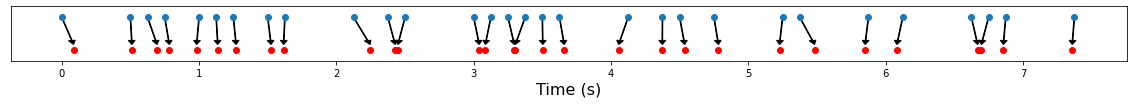

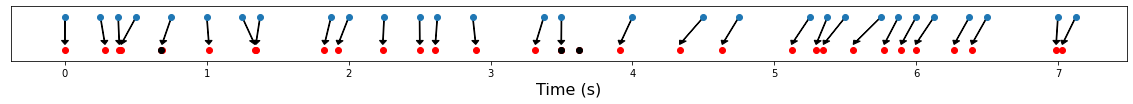

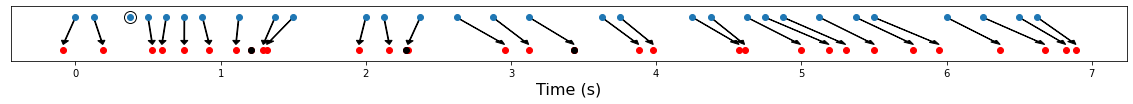

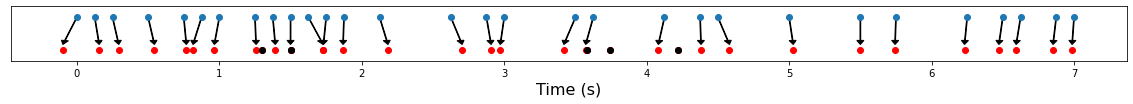

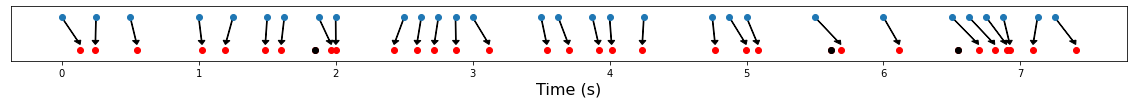

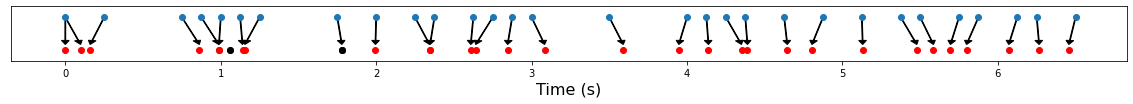

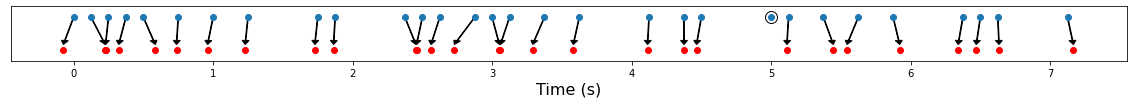

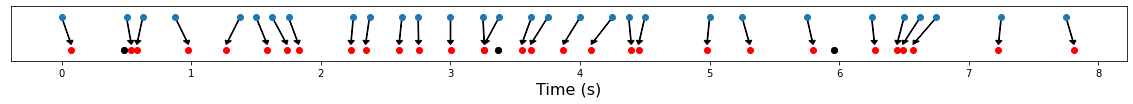

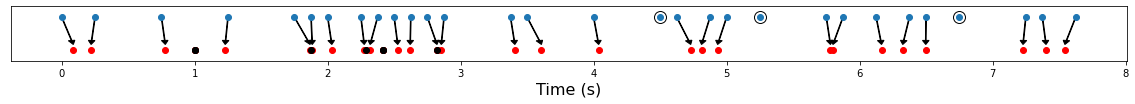

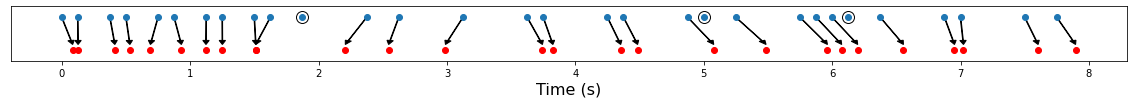

In [90]:
for i in range(len(example_set)):
    m, t, matchings = example_set[i]
    nbt.plot_matching(m, t, matchings)

Dimensions
- Note insertion
- Note deletion
- Space augmentation
- Space reduction
- Length of m
- Rhythms and rhythm pmf
